In [3]:
!pip install --upgrade pip
!pip install opencv-python
!pip install scikit-image


  Using cached pip-25.0.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-25.0.1-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Users\moham\anaconda3\python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier  # CPU-based RF
from sklearn.tree import DecisionTreeClassifier  # CPU-based DT
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog

# Load dataset
DATASET_PATH = ".\\Dataset\\MangoLeafBD Dataset"  # Change this to your dataset path
classes = os.listdir(DATASET_PATH)
print("Classes:", classes)

Classes: ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


In [5]:
# Data preprocessing & Feature Extraction (HOG)
def load_data(dataset_path, img_size=(128, 128)):
    images = []
    labels = []
    
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
                
                # Extract HOG features
                hog_features = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
                images.append(hog_features)
                labels.append(class_name)
    
    return np.array(images), np.array(labels)  

In [6]:
# Load and preprocess the data
X, y = load_data(DATASET_PATH)
print("Data Loaded Successfully!")

Data Loaded Successfully!


In [7]:
# Encode class labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [8]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Train Decision Tree Model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

In [10]:
# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [11]:
# Evaluate models
def evaluate_model(model_name, y_true, y_pred):
    print(f"{model_name} Performance:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("-" * 50)

evaluate_model("Decision Tree", y_test, y_pred_dt)
evaluate_model("Random Forest", y_test, y_pred_rf)

Decision Tree Performance:
Accuracy: 0.5275
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.30      0.34       123
           1       0.65      0.70      0.67        86
           2       0.81      0.84      0.82       112
           3       0.66      0.59      0.62       101
           4       0.38      0.40      0.39       104
           5       0.37      0.39      0.38        90
           6       0.48      0.49      0.49        91
           7       0.46      0.53      0.49        93

    accuracy                           0.53       800
   macro avg       0.52      0.53      0.53       800
weighted avg       0.53      0.53      0.52       800

Confusion Matrix:
 [[37  5  8 14 24 17  8 10]
 [ 2 60  0  0  7  2  4 11]
 [ 1  1 94  1  8  3  1  3]
 [10  1  9 60 12  5  3  1]
 [16  5  4  8 42 15  4 10]
 [14  4  0  4  9 35 17  7]
 [ 8  4  1  3  5 10 45 15]
 [ 7 12  0  1  4  8 12 49]]
---------------------------------------------

In [12]:

# Comparison of model performances
accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("Decision Tree Accuracy:", accuracy_dt)
print("Random Forest Accuracy:", accuracy_rf)


Decision Tree Accuracy: 0.5275
Random Forest Accuracy: 0.78


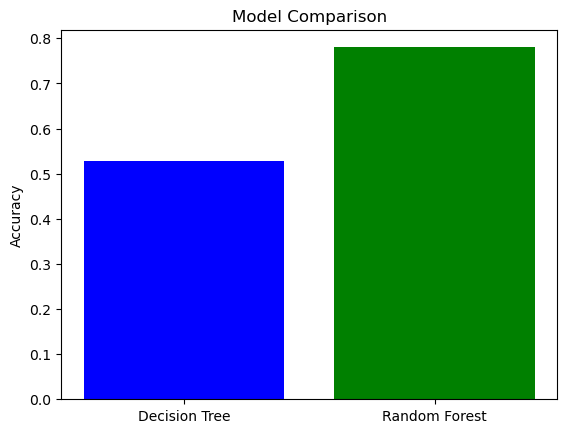

In [14]:
# Plot comparison
plt.bar(["Decision Tree", "Random Forest"], [accuracy_dt, accuracy_rf], color=['blue', 'green'])
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.show()
